In [ ]:
!pip install --prefer-binary scikit-learn==1.0.2
!pip install --prefer-binary xgboost==1.5.2

# Giới thiệu đề tài

Một khoản vay có nên được phê duyệt hay không? Các ngân hàng có thể đánh giá rủi ro của một đơn xin vay mới được không?

Với một bộ dữ liệu khoản vay của Cơ quan quản lý doanh nghiệp nhỏ Hoa Kỳ (U.S. Small Business Administration - SBA) được cung cấp, hãy đưa ra lời khuyên cho ngân hàng để ra quyết định nêu trên.

# Làm rõ yêu cầu

* Mục đích: Bản chất của hoạt động cho vay là dựa trên sự tin tưởng về việc Khách hàng sẽ hoàn trả tiền vay. Trường hợp Khách hàng không trả được nợ sẽ dẫn đến thiệt hại về vốn cho ngân hàng. Một trong các mục đích của ngân hàng là hạn chế các thiệt hại này thông qua nhận diện các Khách hàng xấu để từ chối cho vay. Bên cạnh đó ngân hàng cũng muốn tối đa hoá dư nợ cho vay (quy mô cho vay) từ đó tăng thu nhập từ lãi vay. Điều đó cũng đòi hỏi ngân hàng không từ chối những Khách hàng có nhiều khả năng là Khách hàng tốt.

* Mục tiêu: Để đạt được mục đích đề ra ta cần phải dự đoán được liệu Khách hàng có trả được nợ hay không trong tương lai. Trường hợp kết quả dự đoán là "trả được nợ" thì ngân hàng có thể quyết định cho Khách hàng đó vay. Ngược lại nếu kết quả dự đoán là "không trả được nợ" thì để bảo toàn vốn ngân hàng có thể thông báo từ chối cho vay.

# Xác định cách tiếp cận giải quyết vấn đề

* Có thể thấy bài toán này là một bài toán phân loại với kết quả đầu ra dưới dạng nhị phân (trả được nợ/ không trả được nợ).

* Để xây dựng được mô hình dự đoán như yêu cầu, ta có thể sử dụng các phương pháp học có giám sát để huấn luyện mô hình trên dữ liệu đã có sẵn sau đó sử dụng mô hình để dự đoán cho các quan sát mới.

* Theo yêu cầu này, Các mô hình chọn xây dựng: Logistic Regression, Gradient Boosting

# Xác định các yêu cầu đối với dữ liệu

Với các phương pháp đã lựa chọn, nguồn dữ liệu đầu vào cần đáp ứng các yêu cầu sau:

* Dữ liệu đầu vào là dữ liệu có cấu trúc (bảng gồm hàng và cột);
* Đối tượng cần đánh giá là từng khoản vay do đó mỗi một dòng trong bảng sẽ là một khoản vay đã được cho vay trong một giai đoạn nào đó;
* Mỗi một khoản vay cần được dán nhãn trả được nợ/ không trả được nợ;

# Thu thập dữ liệu

* Nguồn dữ liệu được tải về từ https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied
* Bảng dữ liệu chính nằm trên file SBAnational.csv, ta sẽ sử dụng thư viện Pandas để load dữ liệu vào đối tượng DataFrame để tiện cho việc phân tích ở các bước sau.
* Loại bỏ các dòng chưa được gắn nhãn
* Điều chỉnh các trường hợp gắn nhãn chưa đúng: Có ChgOffDate hoặc có ChgOffPrinGr nhưng gắn nhãn PIF

In [1]:
import pandas as pd

raw_df = pd.read_csv('data/SBAnational.csv')
print(raw_df.shape[0], 'rows loaded')
cond = (~raw_df['ChgOffDate'].isna()) | (raw_df['ChgOffPrinGr'] != '$0.00 ')
cond = cond & (raw_df['MIS_Status']=='P I F')
print(cond.sum(), 'labels change')
raw_df.loc[cond, 'MIS_Status'] = 'CHGOFF'
raw_df = raw_df[~raw_df['MIS_Status'].isna()]
print('Drop NA')
print(raw_df.shape[0], 'rows remain')

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


899164 rows loaded
4927 labels change
Drop NA
897167 rows remain


# Hiểu dữ liệu

In [2]:
import utils

import pandas as pd
import numpy as np
import pickle
import json
from scipy.sparse import save_npz, load_npz

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import *

# Define constant
POSITIVE = 'CHGOFF'
NEGATIVE = 'P I F'
LABELS = [NEGATIVE, POSITIVE]
API_KEY = '545ab510-8aa0-11ec-ad0d-8929d7c50b49'
RANDOM_STATE = 77

## Thời điểm dữ liệu

Đa số các khoản vay có thời hạn 5 năm (IQR1 = 60 tháng). Dữ liệu có các khoản vay đến 2014 do đó từ 2009 - 2014 sẽ thiếu dữ liệu do nhiều khoản vay giải ngân trong giai đoạn này chưa kết thúc, chưa xác định được là tốt hay xấu, do đó ta loại bỏ các khoản vay có ngày giải ngân trong khoảng thời gian này

In [3]:
iqr1 = raw_df['Term'].quantile(0.25)
print('Term IQR1:', iqr1)

disburse = date_value(raw_df[['DisbursementDate']], max_year=2020)['DisbursementDate']
term = pd.DateOffset(months=iqr1)
chgoff = date_value(raw_df[['ChgOffDate']], max_year=2020)['ChgOffDate']
max_chgoff = chgoff.max()
print('Max charge off date:', max_chgoff)
max_disburse = max_chgoff - term
print('Disbursement date less than:', max_disburse)
cond = (disburse < max_disburse)
raw_df = raw_df[cond]
disburse = disburse[cond]
print(raw_df.shape[0], 'rows remain')

Term IQR1: 60.0
Max charge off date: 2014-08-29 00:00:00
Disbursement date less than: 2009-08-29 00:00:00
849674 rows remain


In [4]:
cust_date_df = pd.concat([raw_df['Name'], disburse], axis=1)
oldest_chgoff = cust_date_df[raw_df['MIS_Status']==POSITIVE].groupby('Name', as_index=False).min()

df = cust_date_df.merge(oldest_chgoff, how='left', on='Name')
df.index = cust_date_df.index
raw_df['ChgOffHist'] = df['DisbursementDate_x'] > df['DisbursementDate_y']

## Phân tách tập huấn luyện, tập kiểm tra

Tỷ lệ 75% / 25% 

In [5]:
raw_y = raw_df['MIS_Status'].copy()
raw_df.drop(columns='MIS_Status', inplace=True)

x_train, x_test, y_train, y_test = train_test_split(raw_df,
                                                    raw_y,
                                                    train_size=0.75,
                                                    random_state=RANDOM_STATE,
                                                    stratify=raw_y)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

del raw_df
del raw_y

x_train shape: (637255, 27)
x_test shape: (212419, 27)
y_train shape: (637255,)
y_test shape: (212419,)


## Biến mục tiêu

* Biến mục tiêu có phân phối không đều
* Biến mục tiêu đang được mã thành 2 loại:
    - P I F = 'Paid in full' (Trả được nợ)
    - CHGOFF = 'Charged off' (Không trả được nợ)
* Tại bước chuẩn bị dữ liệu các loại này sẽ được chuyển thành mã 0 và 1 tương ứng.

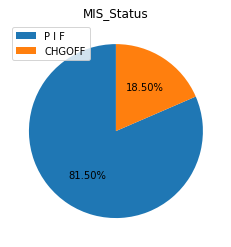

In [6]:
counts = y_train.value_counts()
plt.pie(counts,
        startangle=90,
        autopct='%.2f%%')

plt.title('MIS_Status')
plt.legend(counts.index)
#plt.savefig('chart/mis_status.png')
plt.show()

counts = y_train.value_counts()
WEIGHT = counts[NEGATIVE] / counts[POSITIVE]

## Biến giải thích

Cùng xem qua dữ liệu:

In [ ]:
print('DataFrame head:')
display(x_train.head())
print()

print('Columns details:')
display(get_df_info(x_train))

DataFrame head:


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
187318,2329454006,"CANDELAS GUITARS, INC.",LOS ANGELES,CA,90033,FIRST BANK,CA,339992,16-Sep-98,1998,...,0,N,N,NaN,31-Oct-98,"$119,880.00",$0.00,$0.00,"$119,880.00","$89,910.00"
650367,6523314001,CTB TRASPORTATION SERVICES LC,MOAB,UT,84532,ZIONS FIRST NATIONAL BANK,UT,484110,24-Jul-03,2003,...,2,Y,N,NaN,31-Jul-03,"$147,450.00",$0.00,$0.00,"$100,000.00","$50,000.00"
155823,2133525008,"Lin-Mar Frosty Treats, Inc.",Hampstead,MD,21074,MANUFACTURERS & TRADERS TR CO,NY,311412,20-Nov-06,2007,...,1,Y,N,NaN,31-Mar-07,"$53,047.00",$0.00,$0.00,"$41,000.00","$20,500.00"
849052,9103623001,"LAPIERRE CONCRETE FLATWARE,INC",BERWICK,ME,3901,CITIZENS BANK NATL ASSOC,NH,0,18-Mar-96,1996,...,0,0,N,NaN,30-Apr-96,"$10,000.00",$0.00,$0.00,"$10,000.00","$5,000.00"
330280,3297826001,Universal Trade Systems,CERRITOS (DAIRY VALLEY),CA,90703,BBCN BANK,CA,423390,27-Jun-08,2008,...,1,0,N,NaN,30-Sep-08,"$1,500,000.00",$0.00,$0.00,"$1,500,000.00","$1,350,000.00"



Columns details:


,Column,Count,Null count,Num unique,Type
0,LoanNr_ChkDgt,637255,0,637255,int64
1,Name,637245,10,567080,object
2,City,637229,26,27247,object
3,State,637244,11,51,object
4,Zip,637255,0,30951,int64
5,Bank,636133,1122,5248,object
6,BankState,636127,1128,55,object
7,NAICS,637255,0,1289,int64
8,ApprovalDate,637255,0,8239,object
9,ApprovalFY,637255,0,59,object


### DisbursementGross, GrAppv, SBA_Appv (số tiền giải ngân, số tiền phê duyệt, số tiền SBA bảo lãnh)

* Dữ liệu dưới dạng chuỗi (ví dụ: $10,000.00) cần được chuyển thành float.
* Các phân phối đều lệch phải. Thực hiện biến đổi log, qua biểu đồ trực quan hoá có thể thấy các khoản vay PIF có số tiền lớn hơn khoản vay CHGOFF.
* Nhìn biểu đồ phân tán có thể thấy 3 biến này có quan hệ tuyến tính rõ với nhau. Do đó ta chỉ chọn 1 trong 3 biến để đưa vào huấn luyện.

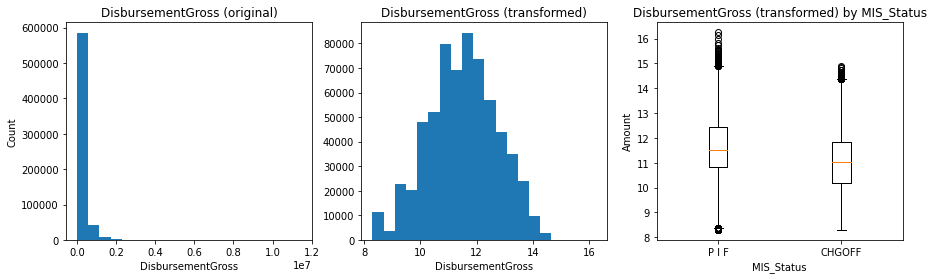

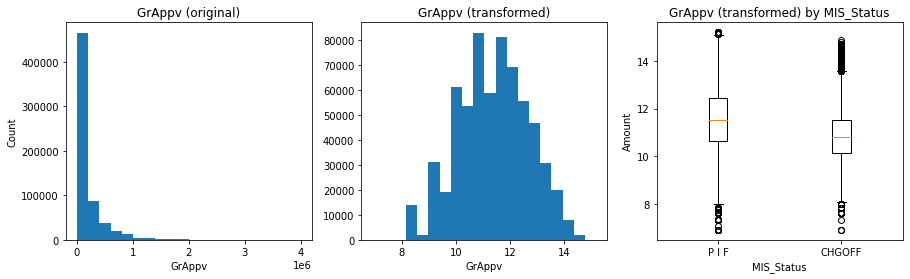

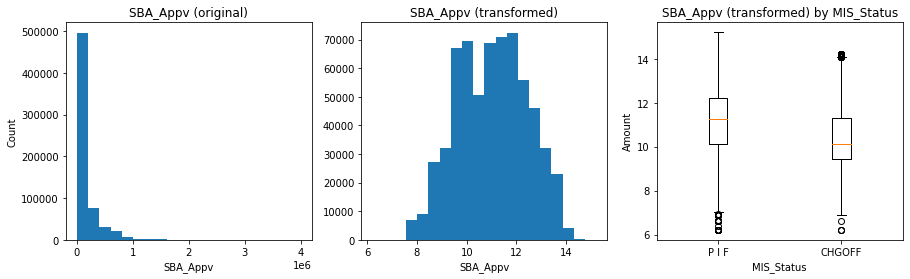

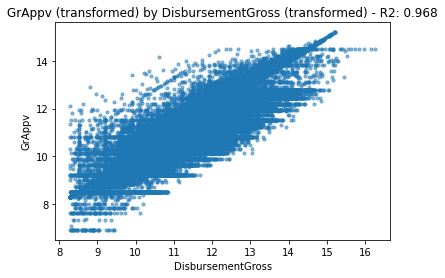

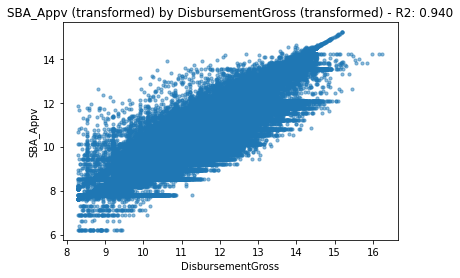

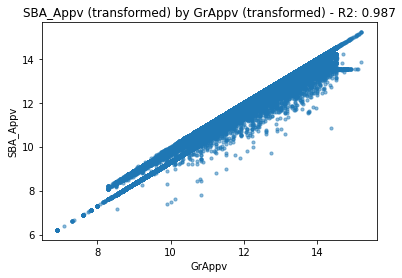

In [ ]:
cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']

amounts = amount_value(x_train[cols])
transformed_amounts = pd.DataFrame(np.log(amounts),
                                   index=amounts.index,
                                   columns=cols)

for col in cols:
    plot_hist_and_boxplot(amounts[col],
                          transformed_amounts[col],
                          y_train,
                          LABELS)
    plt.savefig('chart/' + col + '.png')
plt.show()

pairs = [('DisbursementGross', 'GrAppv'),
         ('DisbursementGross', 'SBA_Appv'),
         ('GrAppv', 'SBA_Appv')]

corr_mat = transformed_amounts.corr()

for f1, f2 in pairs:
    plt.scatter(transformed_amounts[f1],
                transformed_amounts[f2],
                s=10.0,
                alpha=0.5)
    plt.title(f'{f2} (transformed) by {f1} (transformed) - R2: {corr_mat.loc[f1, f2]:.3f}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.savefig('chart/' + f1 + '_' + f2 + '.png')
    plt.show()

### SBA_Appv_Ratio (tỷ lệ bảo lãnh của SBA)

Khi loại bỏ GrAppv và SBA_Appv và thay thế bằng tỷ lệ SBA_Appv / GrAppv thì biến mới này có khả năng giải thích kết quả CHGOFF / PIF. Lý lẽ là khi SBA đánh giá khoản vay có khả năng trả được nợ thì mới chấp nhận tỷ lệ bảo lãnh cao và ngược lại.

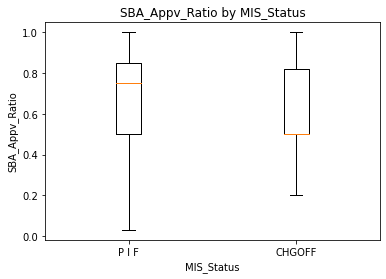

In [ ]:
sba_ratio = amounts['SBA_Appv'] / amounts['GrAppv']
sba_ratio.name = 'SBA_Appv_Ratio'
plot_box(sba_ratio, y_train, LABELS)
plt.savefig('chart/ratio.png')
plt.show()

### BalanceGross

Phần lớn BalanceGross bằng 0 do KH đã trả hết nợ hoặc chuyển thành nợ không trả được do đó cũng có thể bỏ qua.

In [ ]:
print('BalanceGross counts:')
x_train['BalanceGross'].value_counts()

BalanceGross counts:


$0.00           637247
$827,875.00          1
$25,000.00           1
$600.00              1
$37,100.00           1
$395,476.00          1
$996,262.00          1
$41,509.00           1
$12,750.00           1
Name: BalanceGross, dtype: int64

### DisbursementDate (ngày giải ngân)

Ngày giải ngân đến 2009 như phân tích trên. Định dạng dưới dạng chuỗi (ví dụ 3-Jun-89) cần được chuyển đổi thành datetime

In [7]:
disburse_dates = date_value(x_train[['DisbursementDate']], max_year=2020)
disburse_dates = disburse_dates['DisbursementDate']
print('Converted DisbursementDate:')
disburse_dates.dropna().sort_values()

Converted DisbursementDate:


642915   1928-06-18
54648    1948-09-17
697801   1968-03-19
732056   1968-11-22
720402   1969-05-26
            ...    
370525   2009-08-27
369599   2009-08-27
370925   2009-08-27
370179   2009-08-27
369332   2009-08-28
Name: DisbursementDate, Length: 637255, dtype: datetime64[ns]

### ChgOffHist (lịch sử nợ xấu)

* Một khách hàng có thể có nhiều khoản vay.
* Nếu khoản vay trước đó không trả được nợ thì các khoản vay sau đó cũng có xu hướng không trả được nợ

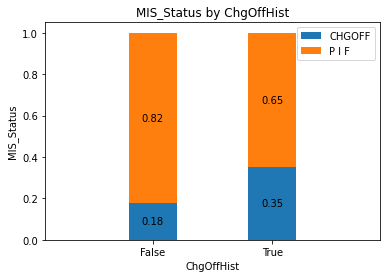

In [ ]:
chgoffhist = x_train['ChgOffHist']

counts = pd.DataFrame(y_train).pivot_table(index=y_train,
                                           columns=chgoffhist,
                                           values=y_train.name,
                                           aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/chgoffhist.png')
plt.show()

### Term (kỳ hạn)

* Kỳ hạn vay không bị thiếu dữ liệu. Tuy nhiên có khoảng 600 trường hợp có kỳ hạn bằng 0 có thể gán giá trị mode.
* Các khoản vay CHGOFF thường có kỳ hạn thấp hơn khoản vay PIF.

Zero Term counts:


False    636652
True        603
Name: Term, dtype: int64

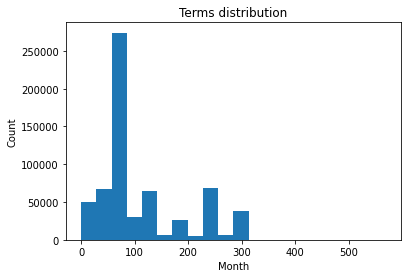

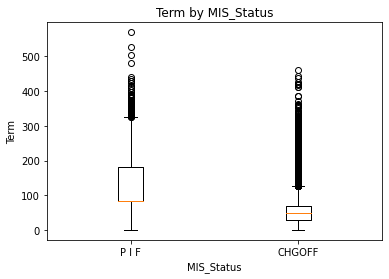

In [ ]:
terms = x_train['Term']
print('Zero Term counts:')
cond = (terms==0)
display(cond.value_counts())

plt.hist(terms, bins=20)
plt.title('Terms distribution')
plt.ylabel('Count')
plt.xlabel('Month')
plt.show()

plot_box(x_train['Term'], y_train, LABELS)
plt.savefig('chart/term.png')
plt.show()

### Recession (suy thoái kinh tế)

* Các khoản vay có trải qua giai đoạn suy thoái kinh tế (tháng 12/2007 đến tháng 6/2009) có tỷ lệ CHGOFF cao hơn các giai đoạn khác. Đây là biến được tạo ra để đưa vào huấn luyện (https://en.wikipedia.org/wiki/Great_Recession)
* Điều kiện xác định khoản vay trải qua giai đoạn suy thoái kinh tế:
    + Ngày hết hạn trước 30/06/2009
    + Ngày giải ngân sau 01/12/2007
    + Trong đó Ngày hết hạn = ngày bắt đầu + kỳ hạn

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


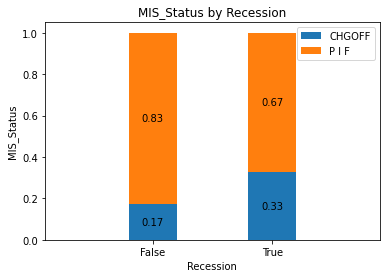

In [8]:
recession = mature_between(disburse_dates,
                           x_train['Term'],
                           '2007-12-01',
                           '2009-06-30')
recession.name = 'Recession'

counts = x_train.pivot_table(index=y_train,
                             columns=recession,
                             values='LoanNr_ChkDgt',
                             aggfunc='count')

portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/recession.png')
plt.show()

### City, State, Zip (thành phố, bang, zip code)

* Số bang = 51 (50 bang + Washington DC), số thành phố, Zip code có gần 30.000 phân loại.
* Các biến này đều thể hiện địa điểm của Khách hàng. Để giảm số lượng nhóm ta sẽ chọn bang (State) để đưa vào huấn luyện.
* Với các trường hợp thiếu dữ liệu có thể suy luận từ mã Zip. Ở đây sử dụng REST API từ [app.zipcodebase.com](app.zipcodebase.com). Các trường hợp còn lại: UNK (unknow)
* Luận điểm ở đây: Mỗi bang ở nước Mỹ có 1 hệ thống pháp luật, môi trường kinh doanh, cơ cấu kinh tế khác nhau do đó có thể có tỷ lệ CHGOFF khác nhau. Ta có thể kiểm chứng qua việc vẽ biểu đồ trực quan hoá.

In [ ]:
cond = x_train['State'].isna()
print('Missing State:')
display(x_train.loc[cond, ['City', 'Zip', 'State']])

zips = x_train.loc[cond, 'Zip']
print('Find State from Zip:')
zip_mapping = zip_to_state(zips, API_KEY)
print('Result:', zip_mapping)

x = pd.DataFrame({'State': state_imputer(x_train, zip_mapping),
                  'Recession': recession})

Missing State:


,City,Zip,State
885335,A452638533,76645,NaN
367007,SOMERSET,54025,NaN
871847,A452638533,76052,NaN
385418,LAKE OZARK,65049,NaN
366139,PALM BEACH GARDENS,33410,NaN
869948,A452638533,75236,NaN
379174,SALT LAKE CITY,84124,NaN
366158,CASCO,54205,NaN
351072,"1542,TABUK,SAUDI ARABIA",79925,NaN
306274,"BOX 267, APO AP",96205,NaN


Find State from Zip:


/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.zipcodebase.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


API request: https://app.zipcodebase.com/api/v1/search?codes=76645%2C54025%2C76052%2C65049%2C33410%2C75236%2C84124%2C54205%2C79925%2C96205%2C95682&country=US
Result: {76645: 'TX', 54025: 'WI', 76052: 'TX', 65049: 'MO', 33410: 'FL', 75236: 'TX', 84124: 'UT', 54205: 'WI', 79925: 'TX', 96205: '', 95682: 'CA'}


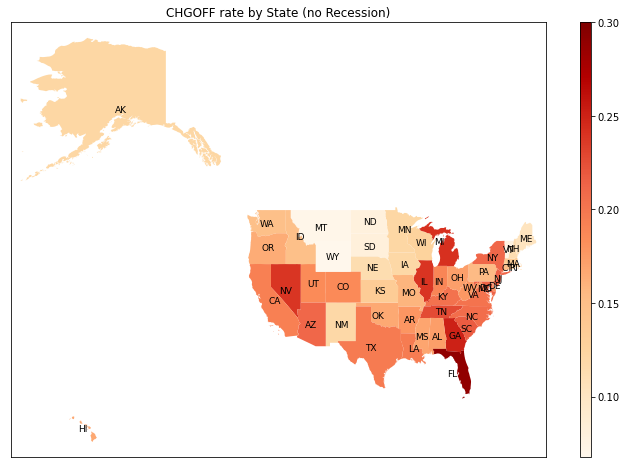

In [ ]:
def plot_states_data(feature, x, y, vmin=None, vmax=None):
    state_rate = target_rate_by_feature(x[feature],
                                        y_train)
    state_rate = state_rate[POSITIVE]

    plot_geospartial(state_rate,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate by {feature} (no Recession)',
                     vmin=vmin,
                     vmax=vmax)

plot_states_data('State', x, y_train, vmin=0.0, vmax=0.3)
plt.savefig('chart/state.png')
plt.show()

### Bank, BankState (ngân hàng, bang của ngân hàng)

Tỷ lệ CHGOFF giữa các BankState cũng có sự khác biệt

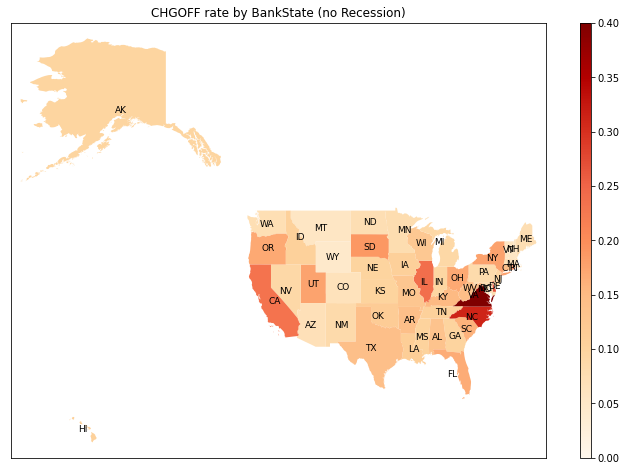

In [ ]:
x = pd.DataFrame({'BankState': x_train['BankState'],
                  'Recession': recession})

plot_states_data('BankState', x, y_train, vmin=0.0, vmax=0.4)
plt.savefig('chart/bankstate.png')
plt.show()

### NAICS (mã ngành)

* Có khoảng 150.000 trường hợp thiếu dữ liệu mã ngành (=0).
* 2 ký tự đầu cột này được code từ 11 - 92 cho mỗi ngành, tổng cộng 24 loại theo bảng tham số naics.csv.
* Thực hiện nhóm các ngành thành nhóm ngành (ví dụ 31, 32, 33 cùng nhóm Manufacturing).
* Các nhóm ngành khác nhau có mức độ rủi ro khác nhau có tỷ lệ CHGOFF sẽ khác nhau.
* Trong thời kỳ suy thoái, sự thay đổi tỷ lệ CHGOFF là khác nhau giữa các ngành (ví dụ Public Administration có tỷ lệ CGHOFF tăng mạnh)

In [9]:
# Get NAICS mapping
naics_map_df = pd.read_csv('data/naics.csv', index_col=0)
NAICS_CODES = naics_map_df['IndustryCode']
print('NAICS mapping:')
display(naics_map_df.head(10))

INDUSTRY_DESC = naics_map_df.groupby('IndustryCode').agg('first').iloc[:, 0]

NAICS mapping:


,IndustryCode,Description
NAICS,,
0,0,Missing
11,1,"Agriculture, forestry, fishing and hunting"
21,2,"Mining, quarrying, and oil and gas extraction"
22,3,Utilities
23,4,Construction
31,5,Manufacturing
32,5,Manufacturing
33,5,Manufacturing
42,6,Wholesale trade


Missing industry counts:


False    486384
True     150871
Name: Industry, dtype: int64

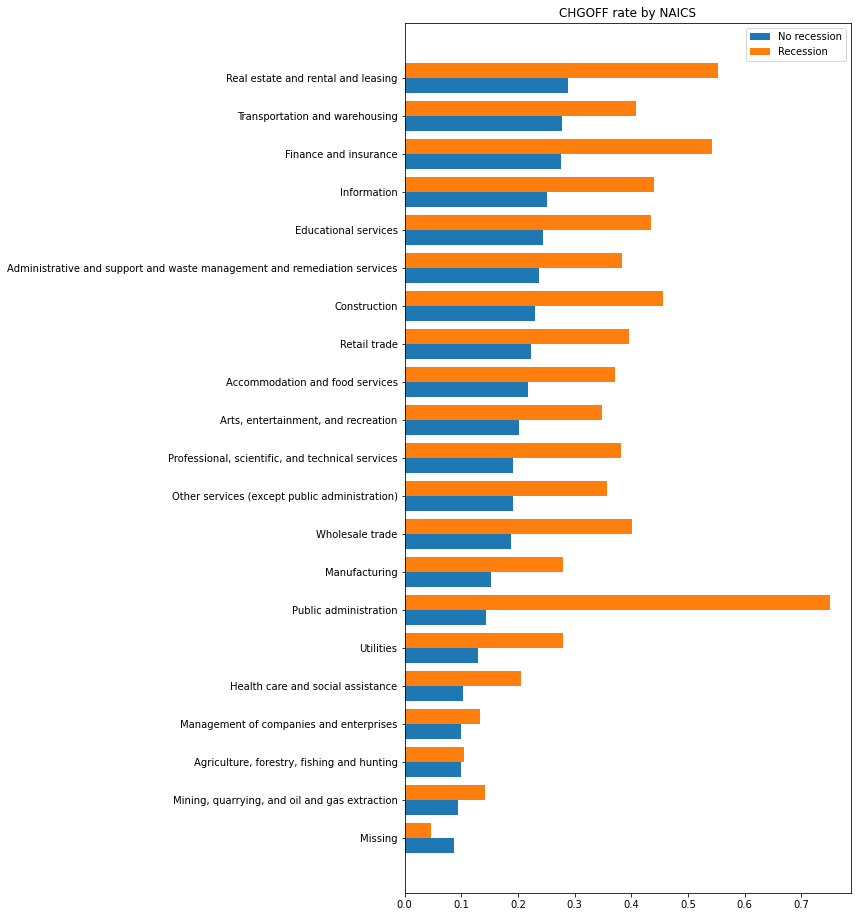

In [ ]:
# Plot industries
x = x_train['NAICS'].map(lambda x: int(str(x)[:2])).map(NAICS_CODES)
x.name = 'Industry'

print('Missing industry counts:')
cond = (x==0)
display(cond.value_counts())

industry = target_rate_by_feature(x[~recession],
                                  y_train[~recession])
industry = industry[POSITIVE]

industry_recession = target_rate_by_feature(x[recession],
                                            y_train[recession])
industry_recession = industry_recession[POSITIVE]

industry_df = pd.concat([industry,
                         industry_recession],
                        axis='columns')
industry_df.index = industry_df.index.astype(np.int64).map(INDUSTRY_DESC)
industry_df.columns = ['No recession', 'Recession']
industry_df = industry_df.sort_values('No recession')
y = np.arange(industry_df.shape[0])
plt.figure(figsize=(8, 16))
plt.barh(y - 0.2, industry_df['No recession'], height=0.4)
plt.barh(y + 0.2, industry_df['Recession'], height=0.4)
plt.yticks(y, industry_df.index)
plt.title(f'{POSITIVE} rate by NAICS')
plt.legend(industry_df.columns)
plt.show()

### NewExist (Khách hàng là doanh nghiệp mới)

* Định nghĩa Khách hàng mới:
    * Khách hàng thành lập trên 2 năm: Giá trị 1
    * Khách hàng thành lập từ 2 năm trở xuống: Giá trị 2
    * Thiếu dữ liệu: Giá trị 0
* Qua quan sát biểu đồ thì biến này không có ảnh hưởng nhiều tới kết quả.
* Có 709 trường hợp thiếu dữ liệu có thể gán bằng 1 (giá trị mode)

NewExist counts:


1.0    457559
2.0    178936
0.0       760
Name: NewExist, dtype: int64

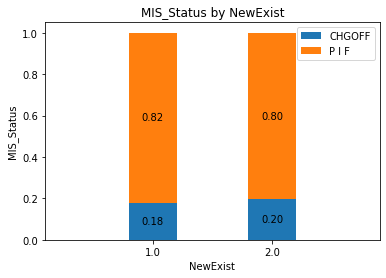

In [ ]:
print('NewExist counts:')
display(x_train['NewExist'].value_counts(dropna=False))

new_exist = x_train['NewExist'].fillna(0)
cond = (new_exist != 0)
counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=new_exist[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

### NoEmp (Số lao động)

* Có khoảng 3300 trường hợp số lao động bằng không có thể thay thế bằng giá trị median
* Phân phối lệch phải. Thực hiện biến đổi log, qua biểu đồ trực quan hoá có thể thấy các khoản vay PIF thì Khách hàng có nhiều lao động hơn khoản vay CHGOFF (Quy mô lớn hơn thì có khả năng trả nợ tốt hơn).

Zero employment counts:


False    633939
True       3316
Name: NoEmp, dtype: int64

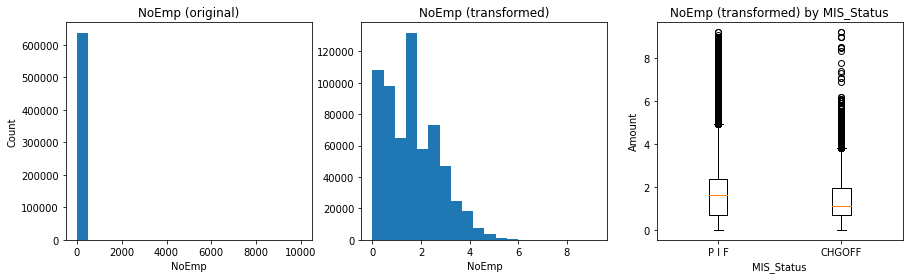

In [ ]:
emp = x_train['NoEmp'].copy()
print('Zero employment counts:')
cond = (emp==0)
display(cond.value_counts())

emp[cond] = emp.median()

plot_hist_and_boxplot(emp,
                      np.log(emp),
                      y_train,
                      LABELS)

plt.savefig('chart/noemp.png')
plt.show()

### FranchiseCode (Nhượng quyền)

* Các giá trị:
    * 0, 1: Không nhượng quyền
    * Các giá trị khác: Có nhượng quyền
* Qua quan sát biểu đồ thì biến này không có ảnh hưởng nhiều tới kết quả.

FranchiseCode counts:


1        476766
0        123334
78760      2418
68020      1420
50564       773
          ...  
84463         1
78240         1
6130          1
55427         1
47854         1
Name: FranchiseCode, Length: 2418, dtype: int64

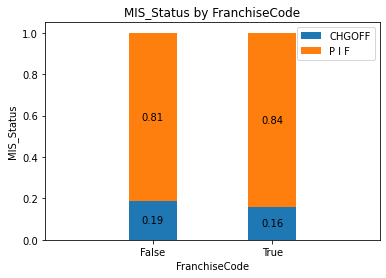

In [10]:
franchise = x_train['FranchiseCode']
print('FranchiseCode counts:')
display(franchise.value_counts())

franchise = (franchise > 1)
counts = pd.DataFrame(y_train).pivot_table(index=y_train,
                                           columns=franchise,
                                           values=y_train.name,
                                           aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/franchise.png')
plt.show()

### UrbanRural (Đô thị, nông thôn)

* Các giá trị:
    * 1: Đô thị
    * 2: Nông thôn
    * 0: Không xác định
* Số lượng quan sát không xác định (0) là lớn (khoảng 240.000)

UrbanRural counts:


1    324343
0    241858
2     71054
Name: UrbanRural, dtype: int64

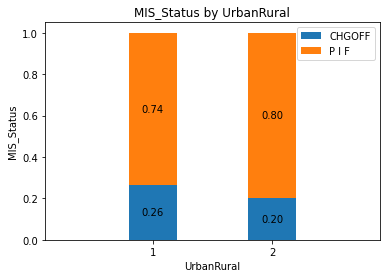

In [11]:
urban_rural = x_train['UrbanRural']
print('UrbanRural counts:')
display(urban_rural.value_counts())
cond = (urban_rural>0)

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=urban_rural[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/urbanrural.png')
plt.show()

### RevLineCr (Vay tuần hoàn)

* Các giá trị:
    * Y: Có
    * N: Không
    * Khác: Lỗi, thiếu dữ liệu
* Số lượng quan sát lỗi, thiếu dữ liệu là lớn (khoảng 200.000)

RevLineCr counts:


N      293310
0      192525
Y      137340
T       11012
NaN      3017
1          20
R          13
`           9
2           2
C           1
,           1
A           1
7           1
5           1
.           1
-           1
Name: RevLineCr, dtype: int64

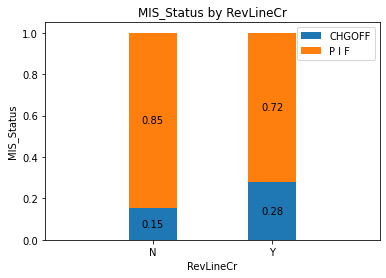

In [12]:
rev_line_cr = x_train['RevLineCr']
print('RevLineCr counts:')
display(rev_line_cr.value_counts(dropna=False))
cond = rev_line_cr.isin(['Y', 'N'])

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=rev_line_cr[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/revlinecr.png')
plt.show()

### LowDoc (Vay ít hồ sơ)

* Các giá trị:
    * Y: Có
    * N: Không
    * Khác: Lỗi, thiếu dữ liệu
* Các trường hợp lỗi, thiếu dữ liệu có thể gán bằng giá trị mode.
* Các trường hợp vay LowDoc có tỷ lệ CHGOFF thấp hơn vay thông thường

LowDoc counts:


N      551335
Y       82699
0        1115
NaN       907
C         559
A         343
S         257
R          39
1           1
Name: LowDoc, dtype: int64

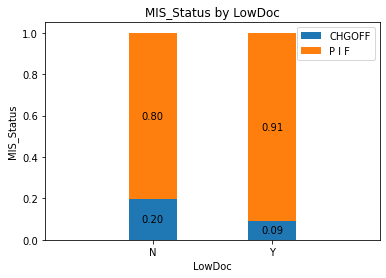

In [ ]:
low_doc = x_train['LowDoc']
print('LowDoc counts:')
display(low_doc.value_counts(dropna=False))
cond = low_doc.isin(['Y', 'N'])

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=low_doc[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.savefig('chart/lowdoc.png')
plt.show()

# Chuẩn bị dữ liệu

## Xây dựng pipeline

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

kfold = KFold(5)

def amount_transformer_func(x):
    x = amount_value(x)
    x['DisbursementGross'] = np.log(x['DisbursementGross'])
    x['SBA_Appv_Ratio'] = x['SBA_Appv'] / x ['GrAppv']
    return x[['DisbursementGross', 'SBA_Appv_Ratio']]

def date_transformer_func(x):
    x = x.copy()
    x[['DisbursementDate']] = date_value(x[['DisbursementDate']], max_year=2020)
    cond = (x['Term']==0)
    x.loc[cond, 'Term'] = x['Term'].mode()[0]
    x['Recession'] = mature_between(x['DisbursementDate'],
                                    x['Term'],
                                    '2007-12-01',
                                    '2009-06-30')
    x['Recession'] = x['Recession'].astype('int')
    x['ChgOffHist'] = x['ChgOffHist'].astype('int')

    return x[['Term', 'Recession', 'ChgOffHist']]

def state_transformer_func(x):
    states = x['State'] 
    cond = states.isna()
    zips = x.loc[cond, 'Zip']
    if len(zips) > 0:
        zip_mapping = zip_to_state(zips, API_KEY)
        states = state_imputer(x, zip_mapping)
    bankstates = x['BankState'].copy()
    cond = bankstates.isna()
    bankstates[cond] = bankstates.mode()[0]
    df = pd.DataFrame({'State': states,
                       'BankState': bankstates})
    return df

def industry_transformer_func(x):
    industry = x['NAICS'].map(lambda x: int(str(x)[:2])).map(NAICS_CODES)
    df = pd.DataFrame({'Industry': industry})
    return df

def noemp_transformer_func(x):
    x = x.copy()
    cond = (x['NoEmp']==0)
    x.loc[cond, 'NoEmp'] = x['NoEmp'].median()
    x['NoEmp'] = np.log(x['NoEmp'])
    return x[['NoEmp']]

def lowdoc_transformer_func(x):
    x = x.copy()
    cond = x['LowDoc'].isna()
    x.loc[cond, 'LowDoc'] = x['LowDoc'].mode()[0]
    x['LowDoc'] = (x['LowDoc'] == 'Y').astype(np.int64)
    return x[['LowDoc']]

def franchise_code_transformer_func(x):
    x = x.copy()
    x['FranchiseCode'] = (~x['FranchiseCode'].isin([0, 1])).astype('int')
    return x[['FranchiseCode']]

def newexist_transformer_func(x):
    x = x.copy()
    cond = (x['NewExist']==0)
    x.loc[cond, 'NewExist'] = x['NewExist'].mode()[0]
    x['NewExist'] = (x['NewExist']==2).astype('int')
    return x[['NewExist']]

def revlinecr_transformer_func(x):
    x = x.copy()
    cond = ~x['RevLineCr'].isin(['Y', 'N'])
    x.loc[cond, 'RevLineCr'] = 'U'
    return x[['RevLineCr']]
    
stage1 = ColumnTransformer([
    ('amount_transformer', FunctionTransformer(amount_transformer_func), ['DisbursementGross', 'SBA_Appv', 'GrAppv']),
    ('date_transformer', FunctionTransformer(date_transformer_func), ['DisbursementDate', 'ApprovalDate', 'Term', 'ChgOffHist']),
    ('state_transformer', FunctionTransformer(state_transformer_func), ['State', 'City', 'Zip', 'BankState']),
    ('industry_transformer', FunctionTransformer(industry_transformer_func), ['NAICS']),
    ('noemp_transformer', FunctionTransformer(noemp_transformer_func), ['NoEmp']),
    ('lowdoc_transformer', FunctionTransformer(lowdoc_transformer_func), ['LowDoc']),
    ('franchise_transformer', FunctionTransformer(franchise_code_transformer_func),['FranchiseCode']),
    ('newexist_transformer', FunctionTransformer(newexist_transformer_func),['NewExist']),
    ('revlinecr_transformer', FunctionTransformer(revlinecr_transformer_func),['RevLineCr']),
    ('urbanrural', 'passthrough', ['UrbanRural'])
])

stage2 = ColumnTransformer([
        ('scaler', MinMaxScaler(), [0, 2, 8]),
        ('encode_state', OneHotEncoder(), [5, 6]),
        ('encode_industry', OneHotEncoder(), [7]),
        ('encode_revlinecr', OneHotEncoder(), [12]),
        ('encode_urbanrural', OneHotEncoder(), [13])
    ],
    remainder='passthrough'
)

stage3 = FunctionTransformer(lambda x: x.astype(np.float32))

stage4 = RFECV(LogisticRegression(solver='lbfgs', max_iter=400, n_jobs=-1, tol=0.0002),
               min_features_to_select=1,
               step=1,
               cv=kfold,
               scoring='f1',
               verbose=1)

x_pipeline = Pipeline([
    ('stage1', stage1),
    ('stage2', stage2),
    ('stage3', stage3),
    ('stage4', stage4)
])

y_pipeline = FunctionTransformer(lambda x: (x==POSITIVE).astype('int'))

## Xử lý dữ liệu

In [9]:
y_train_processed = y_pipeline.fit_transform(y_train)
y_test_processed = y_pipeline.transform(y_test)

In [12]:
x_train_processed = x_pipeline.fit_transform(x_train, y_train_processed)

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.zipcodebase.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


API request: https://app.zipcodebase.com/api/v1/search?codes=76645%2C54025%2C76052%2C65049%2C33410%2C75236%2C84124%2C54205%2C79925%2C96205%2C95682&country=US
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 f

In [13]:
x_test_processed = x_pipeline.transform(x_test)

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.zipcodebase.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


API request: https://app.zipcodebase.com/api/v1/search?codes=0%2C67219&country=US


In [14]:
print('Number of feature:', stage4.n_features_in_)
print('Number of feature after selection:', stage4.n_features_)

Number of feature: 143
Number of feature after selection: 120


In [15]:
categs = stage2.named_transformers_['encode_state'].categories_
cols1 = [feature+'_'+categ for i, feature in enumerate(['State', 'BankState']) for categ in categs[i]]
categs = stage2.named_transformers_['encode_industry'].categories_
cols2 = [feature+'_'+str(categ) for i, feature in enumerate(['Industry']) for categ in categs[i]]
categs = stage2.named_transformers_['encode_revlinecr'].categories_
cols3 = [feature+'_'+str(categ) for i, feature in enumerate(['RevLineCR']) for categ in categs[i]]
categs = stage2.named_transformers_['encode_urbanrural'].categories_
cols4 = [feature+'_'+str(categ) for i, feature in enumerate(['UrbanRural']) for categ in categs[i]]
COL_NAME = ['DisbursementGross', 'Term', 'NoEmp',
            *cols1,
            *cols2,
            *cols3,
            *cols4,
            'SBA_Appv_Ratio',
            'Recession',
            'ChgOffHist',
            'LowDoc',
            'FranchiseCode',
            'NewExist']
print('Features:', COL_NAME)

Features: ['DisbursementGross', 'Term', 'NoEmp', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UNK', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'BankState_AK', 'BankState_AL', 'BankState_AR', 'BankState_AZ', 'BankState_CA', 'BankState_CO', 'BankState_CT', 'BankState_DC', 'BankState_DE', 'BankState_EN', 'BankState_FL', 'BankState_GA', 'BankState_GU', 'BankState_HI', 'BankState_IA', 'BankState_ID', 'BankState_IL', 'BankState_IN', 'BankState_KS', 'BankState_KY', 'BankS

In [16]:
keep = [COL_NAME[int(i[1:])] for i in stage4.get_feature_names_out()]
print('Feature after selection:', keep)

Feature after selection: ['DisbursementGross', 'Term', 'NoEmp', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_IL', 'State_IN', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_OK', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UNK', 'State_UT', 'State_VA', 'State_VT', 'State_WI', 'State_WY', 'BankState_AK', 'BankState_AR', 'BankState_AZ', 'BankState_CA', 'BankState_CO', 'BankState_CT', 'BankState_DC', 'BankState_DE', 'BankState_EN', 'BankState_FL', 'BankState_GA', 'BankState_GU', 'BankState_HI', 'BankState_IA', 'BankState_ID', 'BankState_IL', 'BankState_IN', 'BankState_KS', 'BankState_LA', 'BankState_MA', 'BankState_MD', 'BankState_MI', 'BankState_MN', 'BankState_MS', 'BankState_MT', 'BankState_NC', 'BankState_ND',

In [17]:
drop = [feature for feature in COL_NAME if feature not in keep]
print('Feature dropped:', drop)

Feature dropped: ['State_ID', 'State_KS', 'State_MN', 'State_MO', 'State_NY', 'State_OH', 'State_OR', 'State_PA', 'State_WA', 'State_WV', 'BankState_AL', 'BankState_KY', 'BankState_ME', 'BankState_MO', 'BankState_VI', 'Industry_0', 'Industry_4', 'Industry_8', 'Industry_9', 'Industry_14', 'Industry_15', 'Industry_19', 'Industry_20']


In [18]:
save_npz('x_train_processed.npz', x_train_processed)
save_npz('x_test_processed.npz', x_test_processed)
with open('kept_features.json', 'w') as f:
    json.dump(keep, f)

In [33]:
x_train_processed = load_npz('x_train_processed.npz')
x_test_processed = load_npz('x_test_processed.npz')
with open('kept_features.json', 'r') as f:
    keep = json.load(f)

# Xây dựng mô hình

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

## Phép đo

Phép đo sử dụng để so sánh mô hình
* F1 score

## Mô hình Logistic

Chọn mô hình Logistic có F1 score trên tập validation cao nhất với các giá trị C từ 10e-4 đến 10e4

In [ ]:
# Load pretrain model
with open('lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

In [20]:
param_grid = {
    'C': [1e-4, 1e-2, 1.0, 1e2, 1e4],
    'fit_intercept': [False, True],
    'class_weight': [None, 'balanced'],
}

lr_model = GridSearchCV(LogisticRegression(solver='lbfgs',
                                           max_iter=400,
                                           n_jobs=-1,
                                           tol=0.0002),
                        param_grid,
                        cv=kfold,
                        return_train_score=True,
                        scoring='f1',
                        verbose=1)

lr_model.fit(x_train_processed, y_train_processed)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=400, n_jobs=-1, tol=0.0002),
             param_grid={'C': [0.0001, 0.01, 1.0, 100.0, 10000.0],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [False, True]},
             return_train_score=True, scoring='f1', verbose=1)

In [21]:
print('Best F1 score:', lr_model.best_score_)
print('Best param:', lr_model.best_params_)

Best F1 score: 0.5431769447408594
Best param: {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': False}


In [22]:
# Save model
with open('lr_model.pkl','wb') as f:
    pickle.dump(lr_model, f)

## Mô hình Gradient Boosting

In [22]:
# Load pretrain model
with open('gb_model.pkl', 'rb') as f:
    gb_model = pickle.load(f)

In [23]:
param_grid = {
    'max_depth': [1, 3, 6, 9],
    'learning_rate': [0.1, 0.25, 0.5],
    'gamma': [0, 0.001],
    'scale_pos_weight': [1.0, WEIGHT]
}

gb_model = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False,
                                          objective='binary:logistic',
                                          booster='gbtree',
                                          n_estimators=40,
                                          n_jobs=-1),
                        param_grid,
                        cv=kfold,
                        return_train_score=True,
                        scoring='f1',
                        verbose=1)

gb_model.fit(x_train_processed,
             y_train_processed,
             eval_metric='logloss')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_chil...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                        

In [24]:
print('Best F1 score:', gb_model.best_score_)
print('Best param:', gb_model.best_params_)

Best F1 score: 0.8590322405929888
Best param: {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 9, 'scale_pos_weight': 1.0}


In [25]:
# Save model
with open('gb_model.pkl','wb') as f:
    pickle.dump(gb_model, f)

# Đánh giá mô hình

## So sánh kết quả mô hình

* Căn cứ F1 score có thể thấy mô hình Gradient Boosting cho kết quả tốt nhất giữa 2 mô hình.

In [26]:
def report_f1(x, y):
    print('='*60)
    print('Logistic model:')
    print('='*60)
    yhat = lr_model.predict(x)
    print(classification_report(y, yhat))

    print('='*60)
    print('Gradient Boosting model:')
    print('='*60)
    yhat = gb_model.predict(x)
    print(classification_report(y, yhat))

print('Test F1 score:')
report_f1(x_test_processed, y_test_processed)

Test F1 score:
Logistic model:
              precision    recall  f1-score   support

           0       0.95      0.73      0.82    173115
           1       0.41      0.82      0.54     39304

    accuracy                           0.74    212419
   macro avg       0.68      0.78      0.68    212419
weighted avg       0.85      0.74      0.77    212419

Gradient Boosting model:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    173115
           1       0.89      0.83      0.86     39304

    accuracy                           0.95    212419
   macro avg       0.93      0.90      0.91    212419
weighted avg       0.95      0.95      0.95    212419



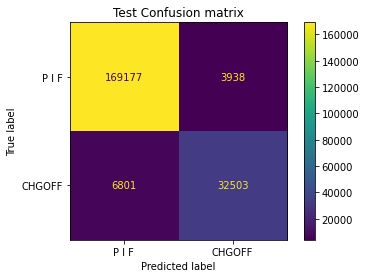

In [25]:
yhat = gb_model.predict(x_test_processed)
m = confusion_matrix(y_test_processed, yhat)
ConfusionMatrixDisplay(m, display_labels=LABELS).plot()
plt.title('Test Confusion matrix')
plt.savefig('chart/confusion-matrix.png')
plt.show()

## Phân tích lỗi

Các trường hợp thiếu dữ liệu RevLineCr, UrbanRural chiếm tỷ lệ cao trong các trường hợp lỗi (34,4%, 35,3%)
Thử impute các trường hợp này bằng giá trị mode, kết quả F1 score không được cải thiện so với việc cho trường hợp lỗi là 1 category.

In [ ]:
df_err = pd.read_csv('errors.csv', index_col=0)

In [28]:
yhat = gb_model.predict(x_test_processed)
error_cond = (y_test_processed!= yhat)
x_test_err = x_test[error_cond]
y_test_err = y_test[error_cond]
df_err = pd.concat([x_test_err, y_test_err], axis=1)
df_err.to_csv('errors.csv')

In [29]:
df_err['RevLineCr'].value_counts() / df_err['RevLineCr'].count()

N    0.466592
0    0.317936
Y    0.189996
T    0.025383
`    0.000093
Name: RevLineCr, dtype: float64

In [30]:
df_err['UrbanRural'].value_counts() / df_err['UrbanRural'].count()

1    0.505354
0    0.353292
2    0.141354
Name: UrbanRural, dtype: float64

In [34]:
x_train_processed = x_train_processed.toarray()
x_test_processed = x_test_processed.toarray()

idx = [i for i, col in enumerate(keep) if col.startswith('UrbanRural')]
x_train_processed = np.delete(x_train_processed, idx, axis=1)
x_test_processed = np.delete(x_test_processed, idx, axis=1)

idx = [i for i, col in enumerate(keep) if col.startswith('RevLineCr')]
x_train_processed = np.delete(x_train_processed, idx, axis=1)
x_test_processed = np.delete(x_test_processed, idx, axis=1)

In [35]:
revlinecr = x_train['RevLineCr'].map({'N': 0, 'Y': 1})
revlinecr[revlinecr.isna()] = revlinecr.mode()[0]
revlinecr = revlinecr.to_numpy().reshape(-1, 1)
urbanrural = x_train['UrbanRural'].map({1: 0, 2: 1})
urbanrural[urbanrural.isna()] = urbanrural.mode()[0]
urbanrural = urbanrural.to_numpy().reshape(-1, 1)
x_train_processed = np.concatenate([x_train_processed, revlinecr, urbanrural],
                                   axis=1)

revlinecr = x_test['RevLineCr'].map({'N': 0, 'Y': 1})
revlinecr[revlinecr.isna()] = revlinecr.mode()[0]
revlinecr = revlinecr.to_numpy().reshape(-1, 1)
urbanrural = x_test['UrbanRural'].map({1: 0, 2: 1})
urbanrural[urbanrural.isna()] = urbanrural.mode()[0]
urbanrural = urbanrural.to_numpy().reshape(-1, 1)
x_test_processed = np.concatenate([x_test_processed, revlinecr, urbanrural],
                                  axis=1)
del revlinecr
del urbanrural
del x_train
del y_train

In [ ]:
# Load pretrain model
with open('gb_model_alt.pkl', 'rb') as f:
    model = pickle.load(f)

In [36]:
model = xgb.XGBClassifier(use_label_encoder=False,
                          objective='binary:logistic',
                          booster='gbtree',
                          n_estimators=40,
                          n_jobs=-1,
                          max_depth=9,
                          gamma=0,
                          learning_rate=0.5,
                          scale_pos_weight=1.0)

model.fit(x_train_processed,
          y_train_processed,
          eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [37]:
# Save model
with open('gb_model_alt.pkl','wb') as f:
    pickle.dump(model, f)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    173115
           1       0.89      0.83      0.86     39304

    accuracy                           0.95    212419
   macro avg       0.93      0.90      0.91    212419
weighted avg       0.95      0.95      0.95    212419



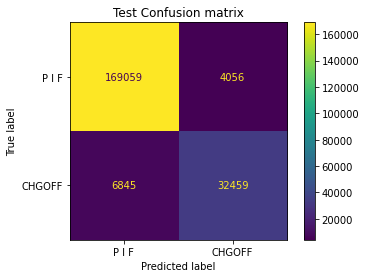

In [41]:
yhat = model.predict(x_test_processed)
print(classification_report(y_test_processed, yhat))
m = confusion_matrix(y_test_processed, yhat)
ConfusionMatrixDisplay(m, display_labels=LABELS).plot()
plt.title('Test Confusion matrix')
plt.savefig('chart/confusion-matrix-alt.png')
plt.show()